# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-06-06 06:06:45.566288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 06:06:45.566378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 06:06:45.695175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preparation

In [2]:
PATH = "/kaggle/input/cremad/AudioWAV/"

# Dataframe

In [3]:
directory_list = os.listdir(PATH)

file_emotion = []
file_path = []

for file in directory_list:
  file_path.append(PATH + file)
  part = file.split('_')
  if part[2] == 'SAD':
    file_emotion.append('sad')
  elif part[2] == 'ANG':
    file_emotion.append('angry')
  elif part[2] == 'DIS':
    file_emotion.append('disgust')
  elif part[2] == 'FEA':
    file_emotion.append('fear')
  elif part[2] == 'HAP':
    file_emotion.append('happy')
  elif part[2] == 'NEU':
    file_emotion.append('neutral')
  else:
    file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns = ['Emotions'])

path_df = pd.DataFrame(file_path, columns = ['Path'])
crema_df = pd.concat([emotion_df, path_df], axis = 1)
crema_df.to_csv("crema_df.csv", index = False)
crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


# Data Visualisation and Exploration

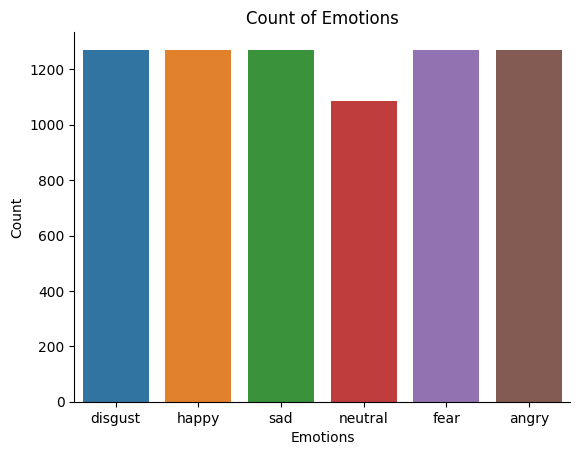

In [4]:
plt.title('Count of Emotions')
sns.countplot(x = crema_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [5]:
def waveplot(data, sr, e):
  plt.figure(figsize = (10, 3))
  plt.title(f"{e} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (12, 3))
  plt.title(f"{e} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

In [12]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def waveplot(data, sr, emotion, ax):
    librosa.display.waveshow(data, sr=sr, ax=ax)
    ax.set_title(f'Waveform ({emotion})')

def spectrogram(data, sr, emotion, ax):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f'Spectrogram ({emotion})')
    return img


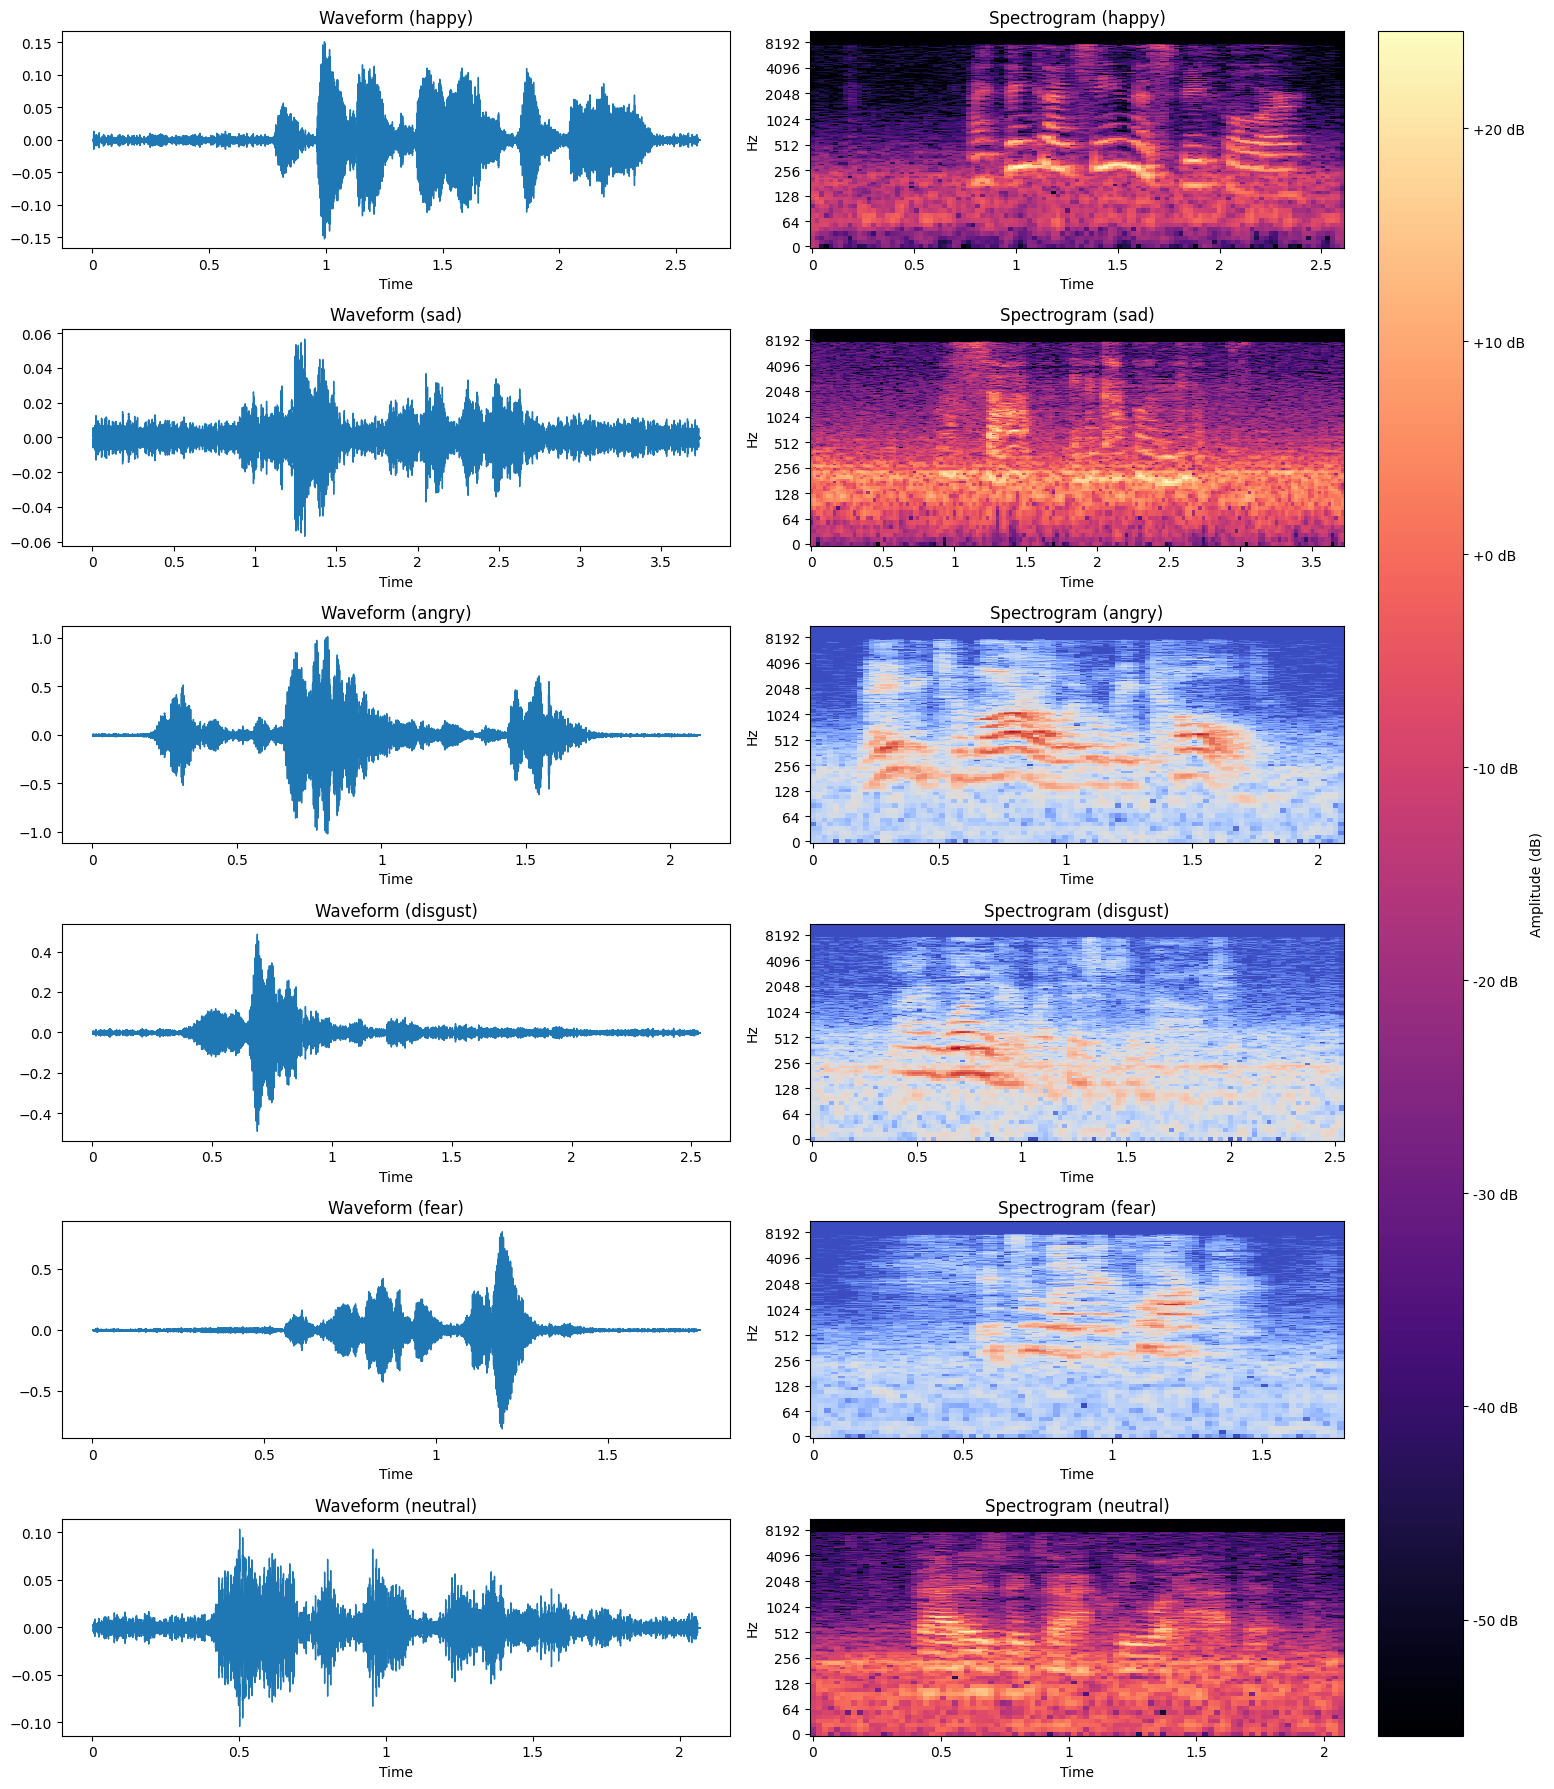

In [14]:
emotions = ['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral']
fig, axs = plt.subplots(len(emotions), 2, figsize=(15, 3 * len(emotions)))
for i, emotion in enumerate(emotions):
    path = np.array(crema_df.Path[crema_df.Emotions == emotion])[1]
    data, sr = librosa.load(path)
    waveplot(data, sr, emotion, axs[i, 0])
    img = spectrogram(data, sr, emotion, axs[i, 1])
plt.tight_layout()
cbar = fig.colorbar(img, ax=axs[:, 1], format="%+2.0f dB")
cbar.ax.set_ylabel('Amplitude (dB)')
plt.show()


# Data Augmentation

In [17]:
def noise(data):
  noise_amp = 0.035 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
  shift_range = int(np.random.uniform(low = -5, high = 5) * 1000)
  return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

path = np.array(crema_df.Path)[1]
data, sample_rate = librosa.load(path)

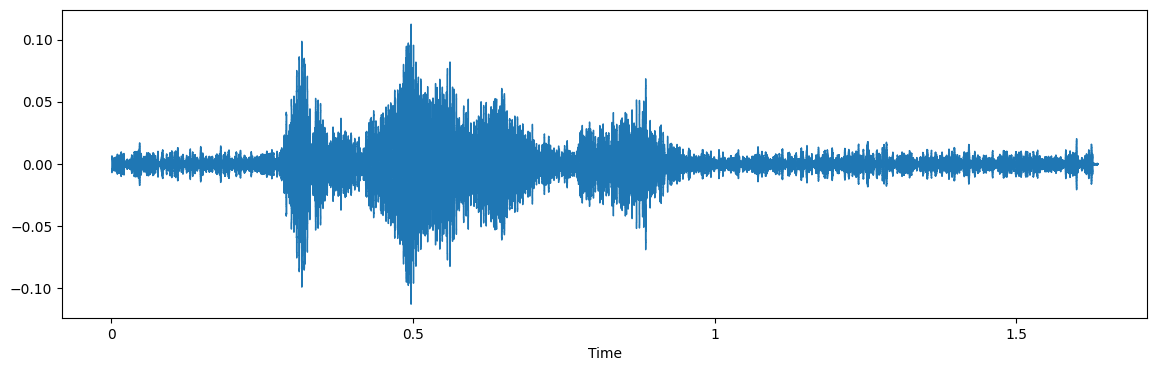

In [18]:
# Simple audio
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = data, sr = sample_rate)
Audio(path)

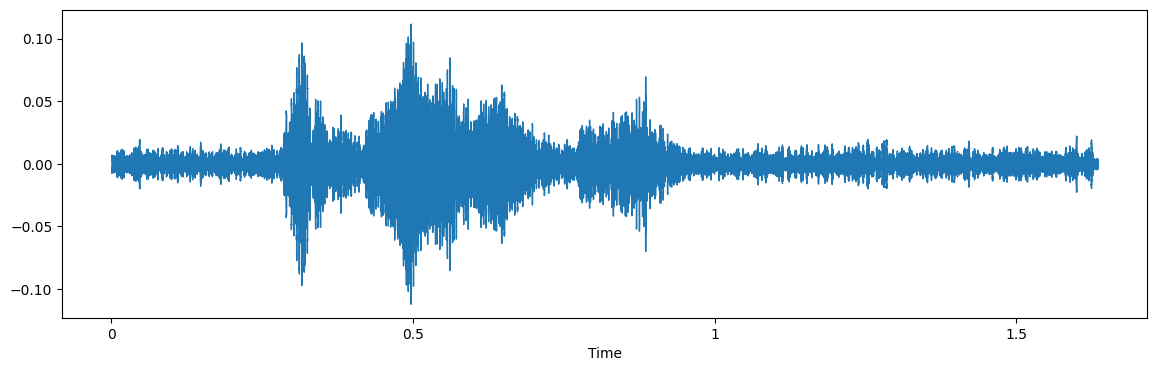

In [19]:
# Noise
x = noise(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

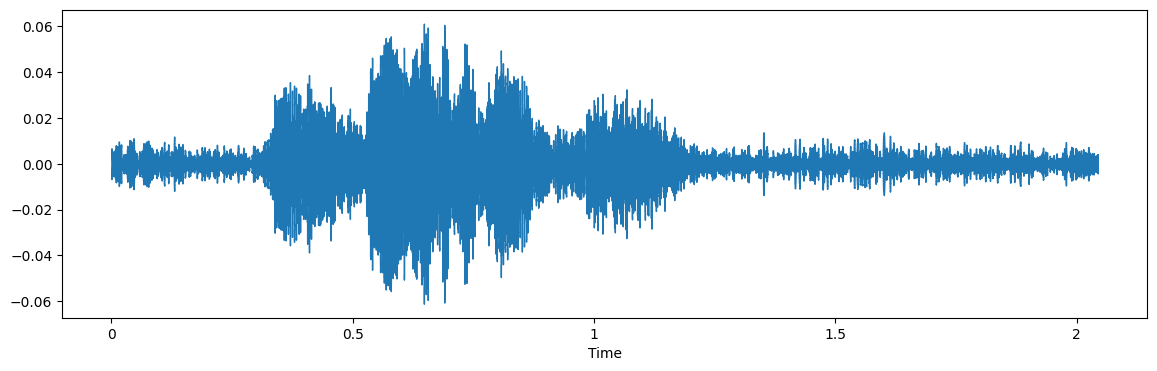

In [20]:
# Stretch
x = stretch(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

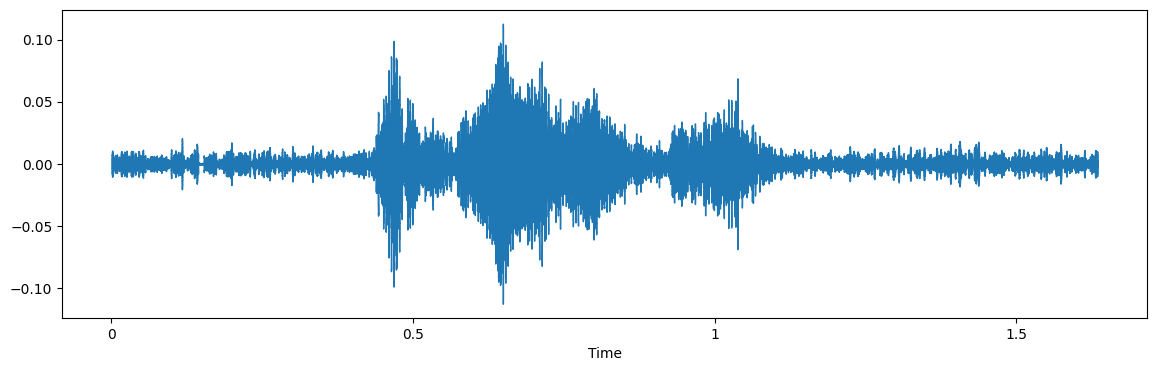

In [21]:
# Shift
x = shift(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

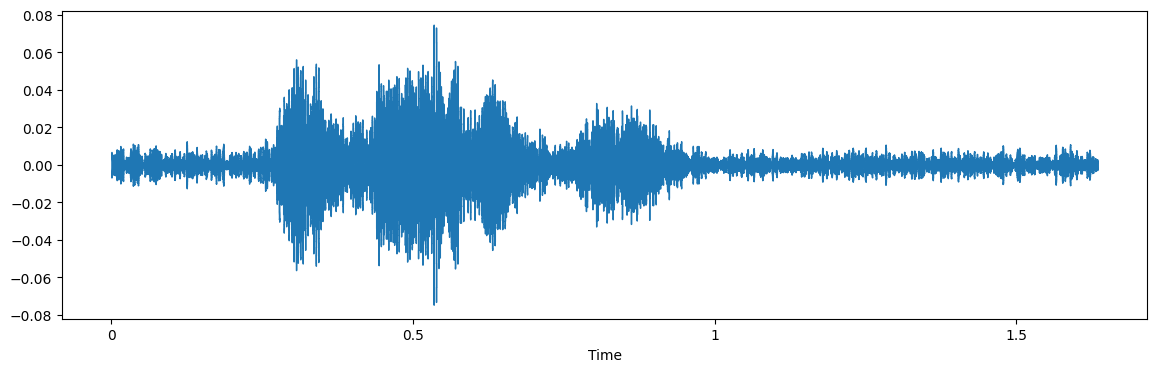

In [22]:
# Pitch
x = pitch(data, sampling_rate = sample_rate)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

# Feature Extraction

In [23]:
def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 20).T, axis = 0)
    result = np.hstack((result, mfcc))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    lowspeed_data = stretch(data, rate = 0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    highspeed_data = stretch(data, rate = 1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    pitch_data = pitch(data, sample_rate, n_steps = 0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6))

    return result

In [24]:
X, Y = [], []
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [25]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(crema_df.Path, crema_df.Emotions):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()
#             print(path, " : ", emotion)

In [26]:
len(X), len(Y), crema_df.Path.shape

(44652, 44652, (7442,))

In [27]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index = False)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-443.894745,144.475601,12.893433,45.324879,-17.744345,29.804256,-9.009513,15.743524,-6.216146,8.669437,...,-8.279094,1.721925,-6.872143,4.674344,-10.990758,2.761565,-11.042257,2.074490,-1.274224,happy
1,-409.441992,106.553231,37.578798,21.764249,4.534493,12.491653,5.334813,4.798038,0.527852,4.758871,...,-6.030578,-2.180385,-1.734420,-1.243865,-5.383691,-2.459638,-6.117636,-1.121414,0.159122,happy
2,-476.988800,139.101151,16.699955,41.115231,-13.670692,27.062695,-5.441456,14.549199,-4.625829,7.492701,...,-8.095484,2.168402,-4.579772,4.784334,-10.023702,1.655565,-9.970422,1.687462,-0.984344,happy
3,-472.713501,142.434616,13.682260,41.582619,-15.914498,27.606339,-7.244491,15.142097,-4.930931,8.497289,...,-8.108882,2.380265,-5.033494,4.205184,-11.127376,1.292563,-11.342902,1.446231,-0.690089,happy
4,-471.154694,139.252762,19.752998,40.621101,-12.026397,29.947216,-8.015689,14.715261,-10.576162,8.424607,...,-5.296573,0.114382,-3.629710,-0.446517,-8.635597,-0.096698,-12.694746,6.114318,-3.908856,happy


# Data Preparation

In [28]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [29]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [31]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [32]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20, 1), (33489, 6), (11163, 20, 1), (11163, 6))

# Modelling

In [ ]:
# model = Sequential([
#     Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
#     MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
#     MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
#     MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
#     MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#     Flatten(),
#     Dense(units=32, activation='relu'),
#     Dropout(0.3),
#     Dense(units=6, activation='softmax'),
# ])

# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# model.summary()

In [33]:
model = Sequential([
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',input_shape = (x_train.shape[1], 1)),
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    
    Flatten(),
    Dense(units = 6, activation = 'softmax'),
    
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,118 (945.77 KB)

 Trainable params: 242,118 (945.77 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
mdcp = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, mdcp])

Epoch 1/100
 43/524 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2269 - loss: 1.7344

I0000 00:00:1717659215.598495     217 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


524/524 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.3491 - loss: 1.5435 - val_accuracy: 0.4288 - val_loss: 1.4119 - learning_rate: 0.0010
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4188 - loss: 1.4054 - val_accuracy: 0.4617 - val_loss: 1.3579 - learning_rate: 0.0010
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4566 - loss: 1.3441 - val_accuracy: 0.4774 - val_loss: 1.3159 - learning_rate: 0.0010
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4878 - loss: 1.2779 - val_accuracy: 0.4897 - val_loss: 1.2656 - learning_rate: 0.0010
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5075 - loss: 1.2271 - val_accuracy: 0.5291 - val_loss: 1.1993 - learning_rate: 0.0010
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5372 - loss: 1.1649 - val_accuracy: 0.5473 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5648 - loss: 1.1007 - val

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8135 - loss: 0.6601
Testing Accuracy:  81.47451281547546 %


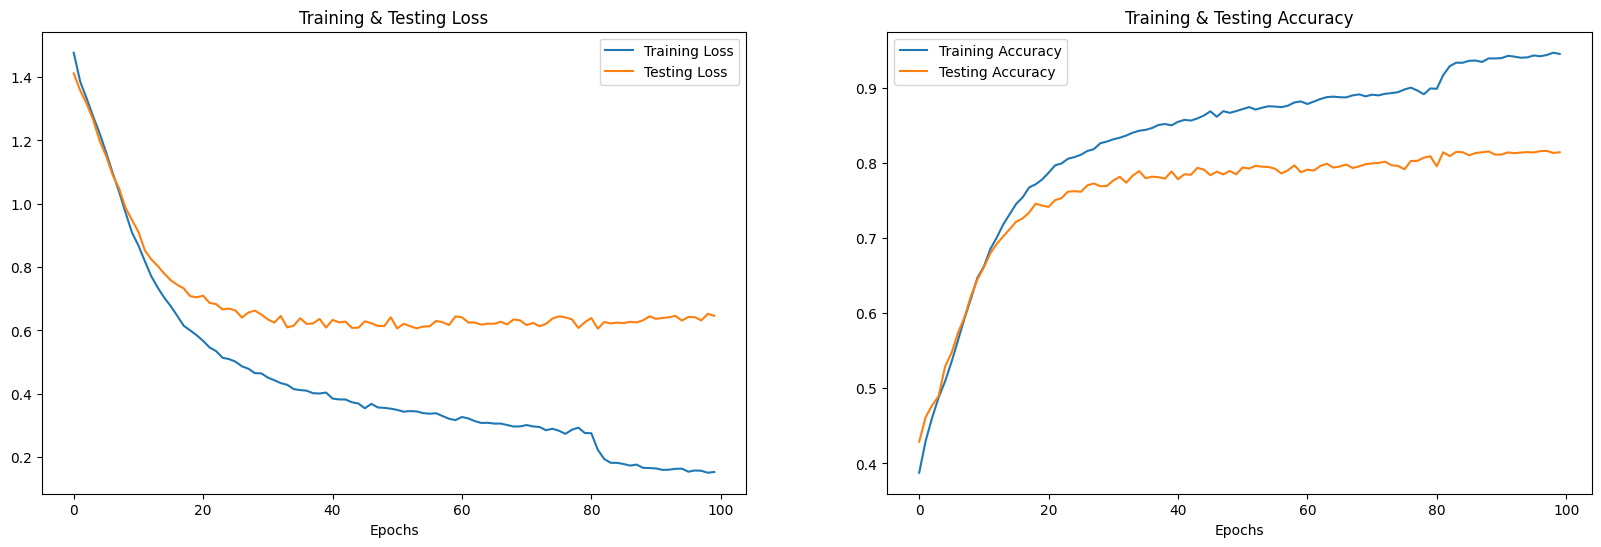

In [35]:
print("Testing Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [36]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [37]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,angry,angry
2,happy,happy
3,disgust,disgust
4,fear,fear
5,neutral,neutral
6,disgust,disgust
7,neutral,neutral
8,fear,fear
9,sad,sad


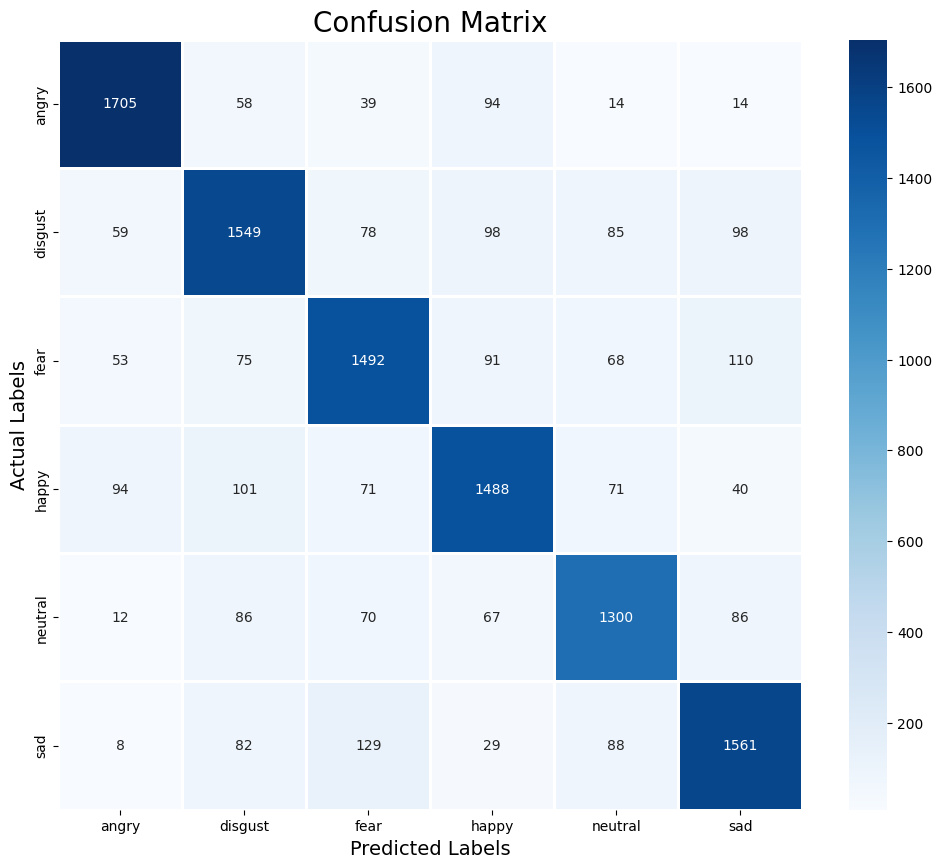

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [39]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

       angry       0.88      0.89      0.88      1924
     disgust       0.79      0.79      0.79      1967
        fear       0.79      0.79      0.79      1889
       happy       0.80      0.80      0.80      1865
     neutral       0.80      0.80      0.80      1621
         sad       0.82      0.82      0.82      1897

    accuracy                           0.81     11163
   macro avg       0.81      0.81      0.81     11163
weighted avg       0.81      0.81      0.81     11163

